# Problem Set 3: Denoising Images & Superpixel maps

# Starting

Run the following code to import the modules and download all the files you'll need.

In [100]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy
from google.colab.patches import cv2_imshow
from skimage import segmentation
from skimage import io, color
import skimage


In [101]:
%%capture

! wget -O img1.bmp "https://drive.google.com/uc?export=download&id=1SpWUZ_0TJ5_K3_u6ZXFwyLDoWVl1wUUo"
! wget -O img2.bmp "https://drive.google.com/uc?export=download&id=1AoR9Od6vJQLYpoDGoh5hEye5-17_p7uC"
! wget -O fhat.png "https://drive.google.com/uc?export=download&id=1Z3w2tZCZLmzD2sSFn063sIaDewaAc7e3"
! wget -O f.png "https://drive.google.com/uc?export=download&id=1TZ41TXhtkIQ-t4pa0dP6z-TxwhTpHIgc"
! wget -O flower.jpg "https://drive.google.com/uc?export=download&id=1qCHktGU-wPJgIgeSGm7Pfe5mFraXk6R5"
! wget -O veggies.jpg "https://drive.google.com/uc?export=download&id=1O5tGFZ5hwPSACK8KJ5S5ULc6ufAMNR7d"
! wget -O porch.jpg "https://drive.google.com/uc?export=download&id=1aRU15CHkEPlUsnUvRFzpb7cWaoxBdQ_2"

# Problem: Mumford-Shah Piecewise Constant

Here I've Implemented a discrete piecewise constant variant of the Mumford-Shah model.

To do that first I implemented the discrete Potts model and test it on a pair of tiny images.

# Visualizing the images

You will use img1 and img2 to test your potts model implementation.

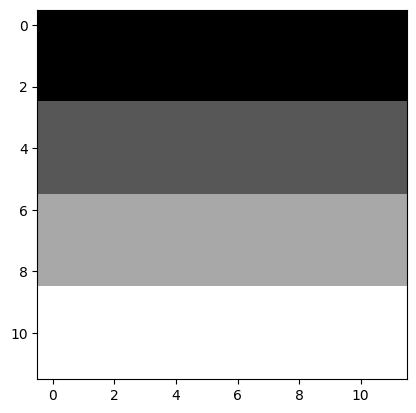

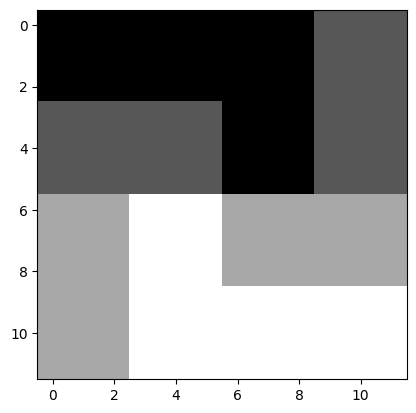

In [102]:
img1 = plt.imread('img1.bmp')
plt.imshow(img1[:,:,0], cmap="gray")
plt.show()

img2 = plt.imread('img2.bmp')
plt.imshow(img2[:,:,0], cmap="gray")
plt.show()

# Potts model

In [103]:
def potts(img, beta=1):
  """function that takes an image and  the hyperparameter beta as inputs and
  return a scalar E representing the potts energy oif the image"""
  E = None
  # ===============================================
  # TODO: replace pass with your code
  rows, cols = img.shape
  E = 0

  for i in range(rows):
    for j in range(cols):
      if (j<(cols-1) and img[i, j] != img[i, j+1]) ^ (i<(rows-1) and img[i, j] != img[i+1, j]):
        E += 1
      elif (j<(cols-1) and img[i, j] != img[i, j+1]) and (i<(rows-1) and img[i, j] != img[i+1, j]):
        E += 2

  E *= beta

  # ===============================================
  return E

# Check your Potts model

You should get 0 error for both images.

In [104]:
print("Error for energy of img1: ", 36 - potts(img1[:,:,0]))
print("Error for energy of img2: ",42 - potts(img2[:,:,0]))


Error for energy of img1:  0
Error for energy of img2:  0


# Visualizing the images

You will use f and f_hat to test your implementation of the mumford_shah function. The image f is noisy and f_hat is a denoised version of f.



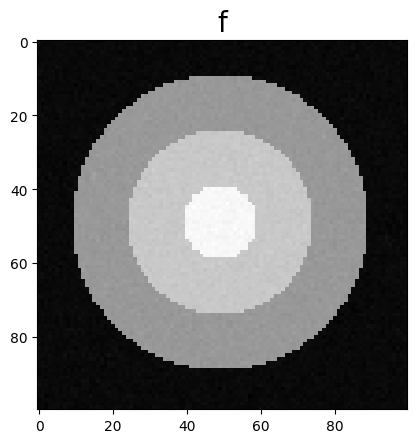

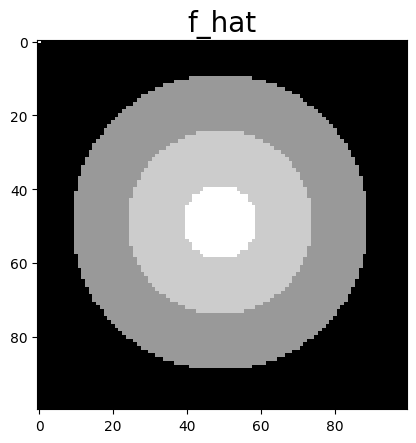

In [105]:
f = plt.imread('f.png')
plt.title("f", fontsize=20)
plt.imshow(f, cmap="gray")
plt.show()

plt.title("f_hat", fontsize=20)
f_hat = plt.imread('fhat.png')
plt.imshow(f_hat,cmap="gray")
plt.show()

# Implement the Mumford Shah model

You will now implement the mumford shah function. We usually use this model in an optimization scenario where we try to find the image (f_hat) that minimizes the value of $E_{PC}$. In this case, we won't be actually minimizing anything. Instead, to test your implementation we are providing you with a denoised image (f_hat). This denoised image may or may not be the BEST denoised image (the image that minimizes the mumford_shah model).

In [106]:
def mumford_shah(f_hat, f = f, alpha=1, gamma=0.1, beta=1):
  """ The function takes a denoise image (f_hat), the original image (f), an
  three hyperparameters (alpha, gamma, beta). The function returs a single value
  E_pc.

  Think about how this function uses the potts model that you implemented before.
  Were is the beta parameter used?
  """
  E_pc = None
  # ===============================================
  # TODO: replace pass with your code
  E_pc = alpha*np.sum(np.square(f-f_hat)) + gamma*np.abs(potts(f_hat, beta=1))

  # ===============================================
  return E_pc


# Check your mumford shah model

This is a sanity check to help you debug your results.

In [107]:
print("Error: ", 67.61031913757324 - mumford_shah(f_hat))

Error:  0.0


# Problem: Foreground-background graph-cut

In this problem I've implemented a foreground-background segmentation method using the max-flow/min-cut method. Below is the implementation of the histogram feature representation and all aspects of taking the superpixel result and implementing the graph on top of it as well as reading out the results of the graph cut as a two-class segmentation.

# Visualizing the images

For this problem we will be working with an image of some vegetables, a porch and a flag.

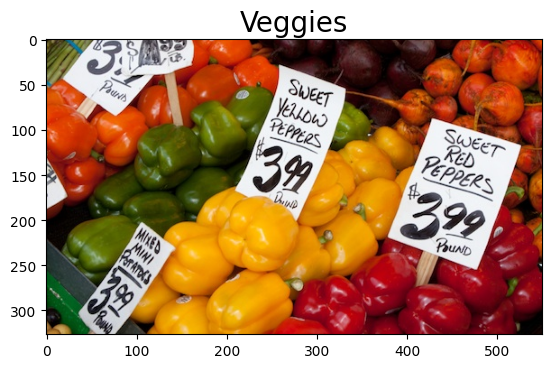

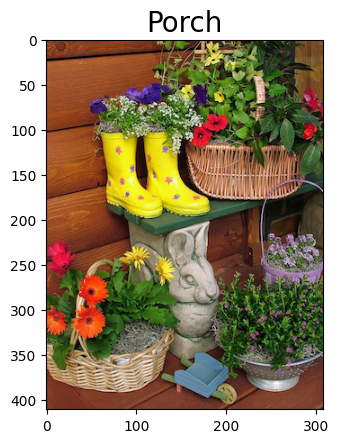

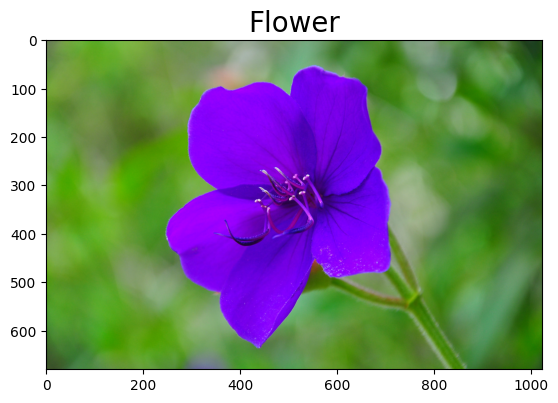

In [108]:
veggies = plt.imread('veggies.jpg')
veggies = veggies[:,:,:3]
plt.title("Veggies", fontsize=20)
plt.imshow(veggies)
plt.show()

porch = plt.imread('porch.jpg')
porch = porch[:,:,:3]
plt.title("Porch", fontsize=20)
plt.imshow(porch)
plt.show()

flower = plt.imread('flower.jpg')
flower = flower[:,:,:3]
plt.title("Flower", fontsize=20)
plt.imshow(flower)
plt.show()


# Creating the superpixel maps

The code below will make superpixel maps of our three images. We use the skimage implementation of the SLIC superpixel algorithm. Here is a great medium article explaining how the algorithm works: https://medium.com/@darshita1405/superpixels-and-slic-6b2d8a6e4f08. This algorithm generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. We provide a lot of functions for you. The output of the slic function is a label map (every segment has a differnt number assigned to it).

For visualization purposed we use the function label2rgb to convert this map to a 3-channel image where every label is assigned a color. We also use the function apply_supermap to assign the color of the cluster centers to every pixel of their corresponding segmentation groups.

In [109]:
def label2rgb(labels):
  """
  Convert a labels image to an rgb image using a matplotlib colormap
  """
  label_range = np.linspace(0, 1, 256)
  lut = np.uint8(plt.cm.viridis(label_range)[:,2::-1]*256).reshape(256, 1, 3) # replace viridis with a matplotlib colormap of your choice
  return cv2.LUT(cv2.merge((labels, labels, labels)), lut)

In [110]:
def cluster_centers(superpixel_map):
  """
  This function takes a superpixel map and returns a list with the
  (row,col) positions of the cluster centers for that map
  """

  unique_labels = np.unique(superpixel_map)
  cluster_center_list = []

  for label_id, superpixel_label in enumerate(unique_labels):

      # Compute the coordinates where we have the superpixel_map = current label

      cluster_indices = np.where(superpixel_map == superpixel_label)

      # Compute the centroid of the coordinates to find the cluster centers

      centers = np.round(np.mean(cluster_indices, axis = 1)).astype('int')
      cluster_center_list.append(centers)

  return cluster_center_list

In [111]:
def apply_supermap(img, superpixel_map):
  """ This function returns an image where we assign the color of the cluster centers
  to every pixel of their corresponding segmentation groups."""
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    out[superpixel_map == i] = img[row, col]
  return out


# Visualizing SLIC superpixel maps

<ipython-input-112-73cf9c46843a>:1: FutureWarning: `max_iter` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  super_veggies = segmentation.slic(veggies, n_segments=144, compactness=20, max_iter=20, start_label = 0) ##################### CHANGED
<ipython-input-112-73cf9c46843a>:2: FutureWarning: `max_iter` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  super_porch = segmentation.slic(porch, n_segments=144, compactness=20, max_iter=20, start_label = 0) ##################### CHANGED
<ipython-input-112-73cf9c46843a>:3: FutureWarning: `max_iter` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  super_flower = skimage.segmentation.slic(flower, n_segments=144, compactness=20, max_iter=20, start_label = 0) ##################### CHANGED


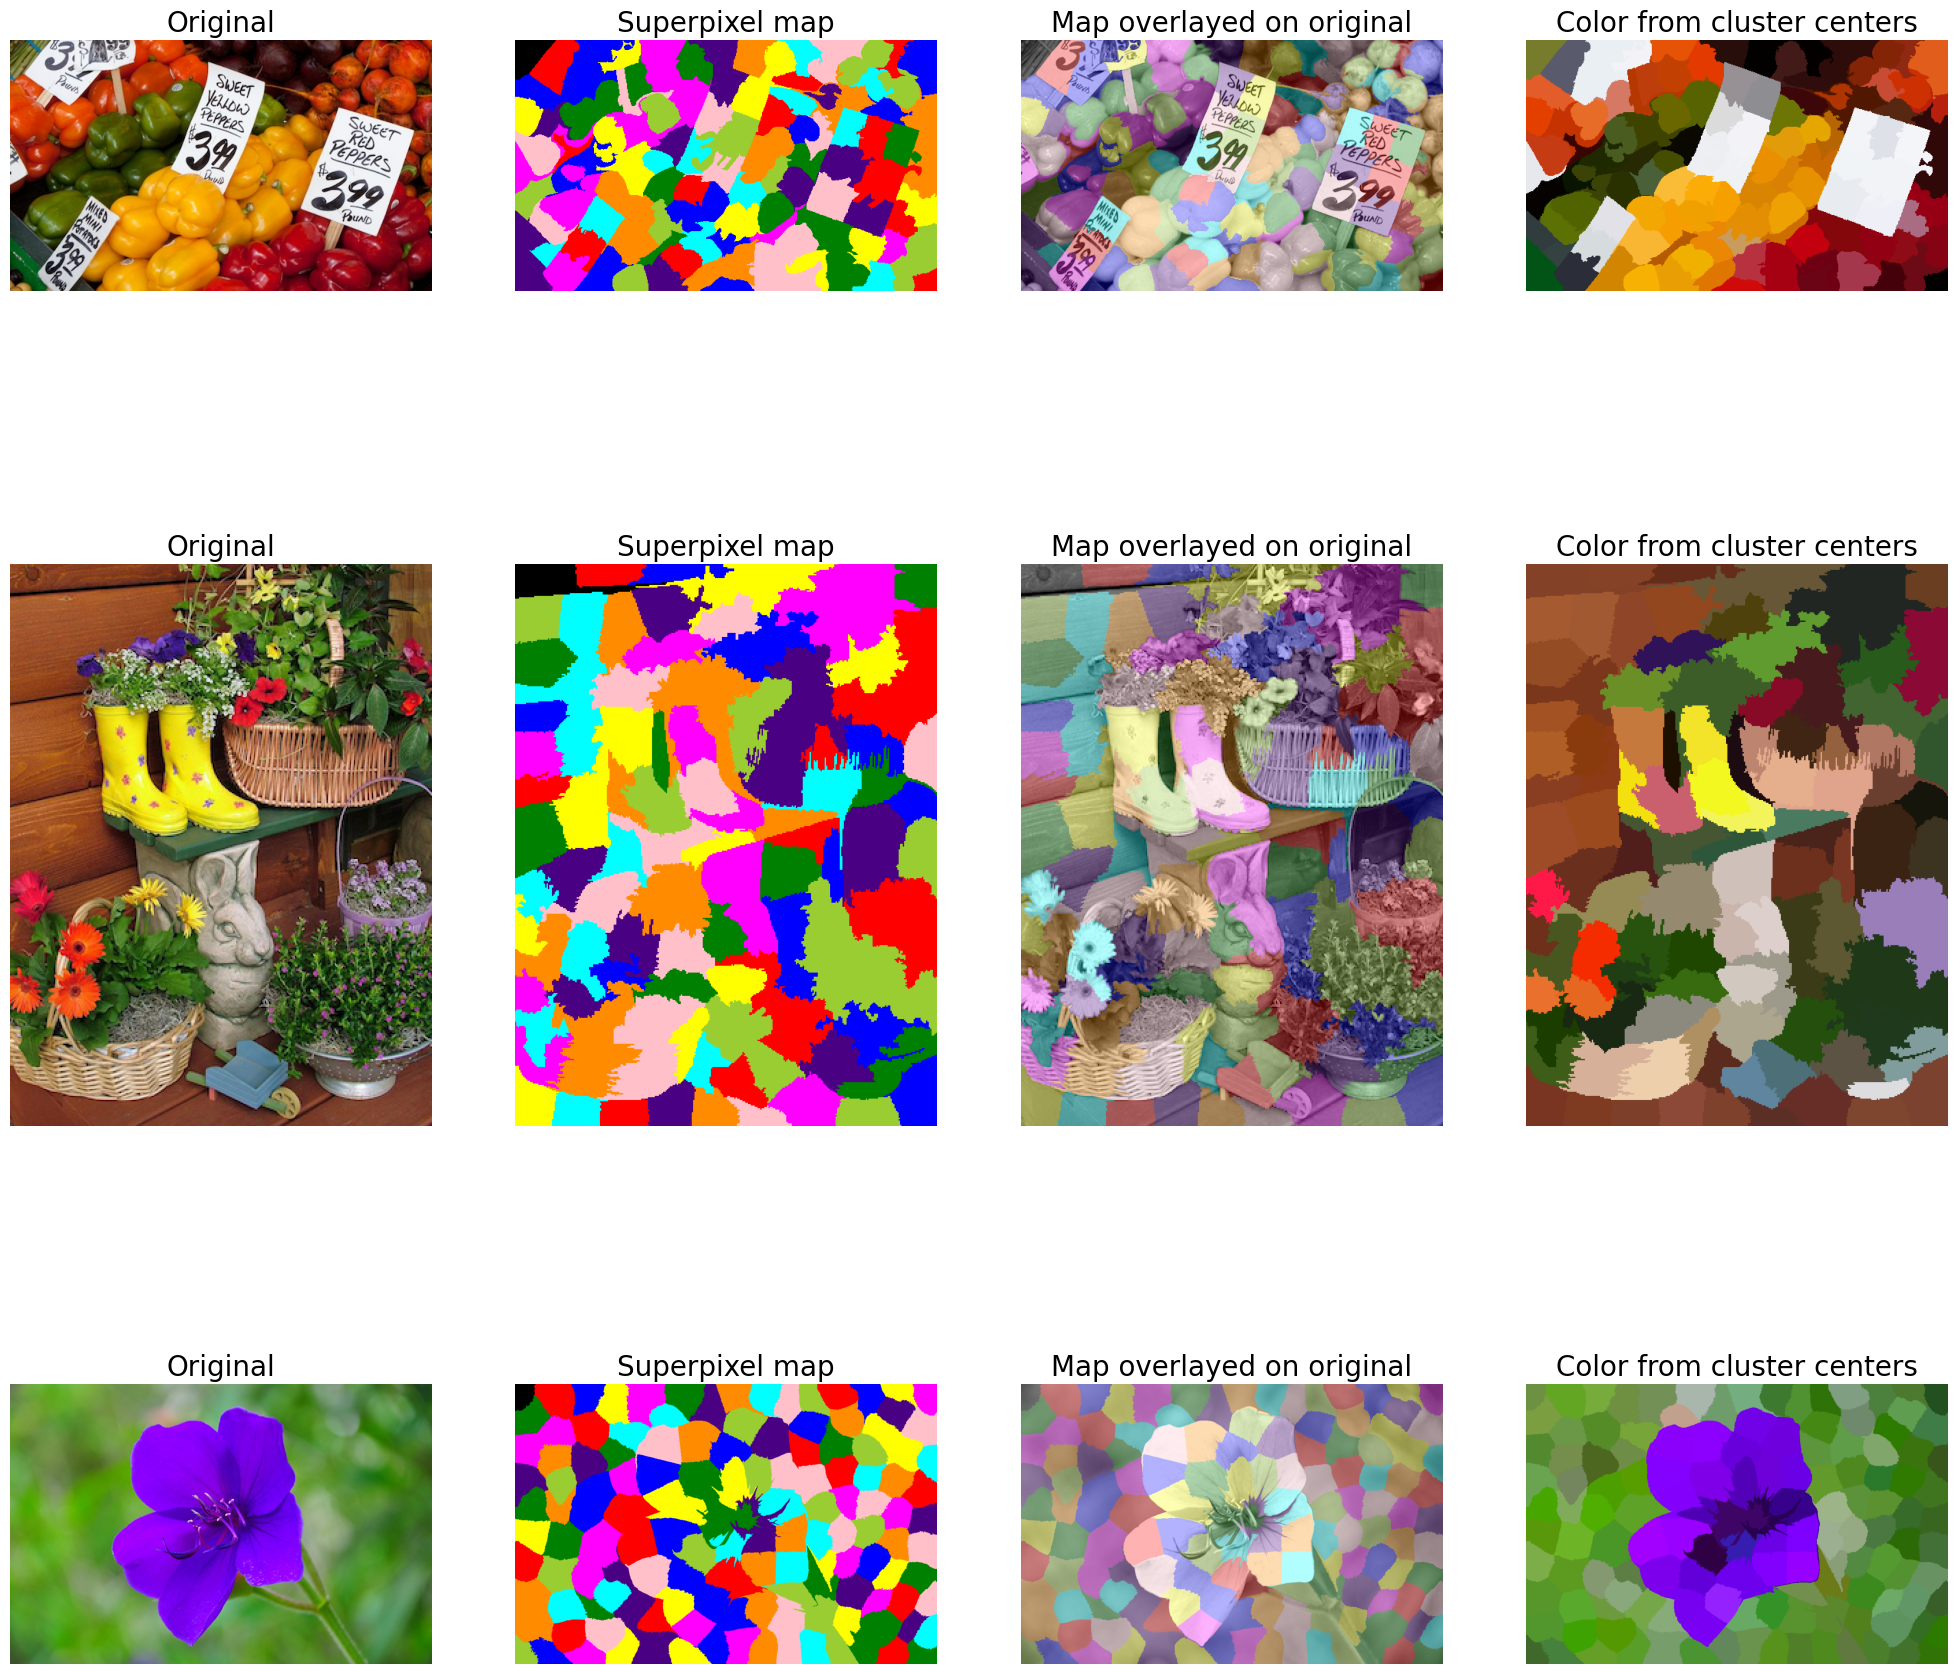

In [112]:
super_veggies = segmentation.slic(veggies, n_segments=144, compactness=20, max_iter=20, start_label = 0) ##################### CHANGED
super_porch = segmentation.slic(porch, n_segments=144, compactness=20, max_iter=20, start_label = 0) ##################### CHANGED
super_flower = skimage.segmentation.slic(flower, n_segments=144, compactness=20, max_iter=20, start_label = 0) ##################### CHANGED

fig, ax = plt.subplots(3, 4, figsize=(25,25))
images = [veggies, porch, flower]
maps = [super_veggies, super_porch, super_flower]

for i,a in enumerate(ax):
  a[0].set_axis_off()
  a[0].set_title('Original', fontsize=20)
  a[0].imshow(images[i])
  a[1].set_axis_off()
  a[1].set_title('Superpixel map', fontsize=20)
  a[1].imshow(skimage.color.label2rgb(maps[i]))
  a[2].set_axis_off()
  a[2].set_title('Map overlayed on original', fontsize=20)
  a[2].imshow(skimage.color.label2rgb(maps[i], images[i]))
  a[3].set_axis_off()
  a[3].set_title('Color from cluster centers', fontsize=20)
  a[3].imshow(apply_supermap(images[i], maps[i]))



# Implement color histogram

Next is the implementation of the function color_histogram. This function takes an image, a binary mask and the number of bins that you want to use for every channel. The function will compute the histogram over the 1 values in the mask only.

In [113]:
def color_histogram(img, mask, num_bins):
  """For each channel in the image, compute a color histogram with the number of bins
  given by num_bins of the pixels in
  image where the mask is true. Then, concatenate the vectors together into one column vector (first
  channel at top).

  Mask is a matrix of booleans the same size as image.

  You MUST normalize the histogram of EACH CHANNEL so that it sums to 1.
  You CAN use the numpy.histogram function.
  You MAY loop over the channels.
  The output should be a 3*num_bins vector because we have a color image and
  you have a separate histogram per color channel.

  Hint: np.histogram(img[:,:,channel][mask], num_bins)"""

  rows, cols, channels = img.shape
  histogram = np.zeros(num_bins*3)

  # ===============================================
  # TODO: replace pass with your code
  for i in range(channels):
    unnorm_hist, _ = np.histogram(img[:,:,i][mask==True], num_bins)
    norm_hist = unnorm_hist/np.sum(unnorm_hist)

    histogram[i*num_bins:(i+1)*num_bins] = norm_hist

  # ===============================================

  return histogram



# Check histogram implementation

This will check if your implementation is correct. The error should be very close to 0 (~e-8)

In [114]:
histogram = color_histogram(veggies, super_veggies==90, 10)
correct_histogram = np.array([0.01069855, 0.01510384, 0.00881057, 0.02580239, 0.16991819,
       0.33480176, 0.33920705, 0.07866583, 0.01258653, 0.00440529,
       0.87413468, 0.07426054, 0.0188798 , 0.01195721, 0.0094399 ,
       0.00566394, 0.00188798, 0.00251731, 0.        , 0.00125865,
       0.73127753, 0.20830711, 0.02139711, 0.01069855, 0.01384519,
       0.00566394, 0.00440529, 0.00314663, 0.        , 0.00125865])

error = np.sum((correct_histogram - histogram)**2)
print("Error: ", error)

Error:  2.1084251864217788e-16


# Adjacency matrix

Adjacency matrix function that takes a superpixel map as an input and outputs a binary adjacency matrix.

In [115]:
def adjacencyMatrix(superpixel_map):
  """Implement the code to compute the adjacency matrix for the superpixel map
  The input is a superpixel map and the output is a binary adjacency matrix NxN
  (N being the number of superpixels in svMap).  Bmap has a 1 in cell i,j if
  superpixel i and j are neighbors. Otherwise, it has a 0.  Superpixels are neighbors
  if any of their pixels are neighbors."""

  segmentList = np.unique(superpixel_map)
  segmentNum = len(segmentList)
  adjMatrix = np.zeros((segmentNum, segmentNum))

  # ===============================================
  # TODO: replace pass with your code
  rows, cols = superpixel_map.shape

  for i in range(rows):
    for j in range(cols):
        if (i>0) and superpixel_map[i, j] != superpixel_map[i-1, j]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i-1, j]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (j>0) and superpixel_map[i, j] != superpixel_map[i, j-1]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i, j-1]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (i<(rows-1)) and superpixel_map[i, j] != superpixel_map[i+1, j]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i+1, j]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (j<(cols-1)) and superpixel_map[i, j] != superpixel_map[i, j+1]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i, j+1]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (i>0 and j>0) and superpixel_map[i, j] != superpixel_map[i-1, j-1]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i-1, j-1]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (i>0 and j<(cols-1)) and superpixel_map[i, j] != superpixel_map[i-1, j+1]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i-1, j+1]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (i<(rows-1) and j>0) and superpixel_map[i, j] != superpixel_map[i+1, j-1]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i+1, j-1]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1
        elif (i<(rows-1) and j<(cols-1)) and superpixel_map[i, j] != superpixel_map[i+1, j+1]:
          neighbor_1 = superpixel_map[i, j]
          neighbor_2 = superpixel_map[i+1, j+1]
          adjMatrix[neighbor_1, neighbor_2] = 1
          adjMatrix[neighbor_2, neighbor_1] = 1



  # ===============================================

  return adjMatrix

# Visualize your implementation

The following code will show the adjacency matrices for the 4 images.

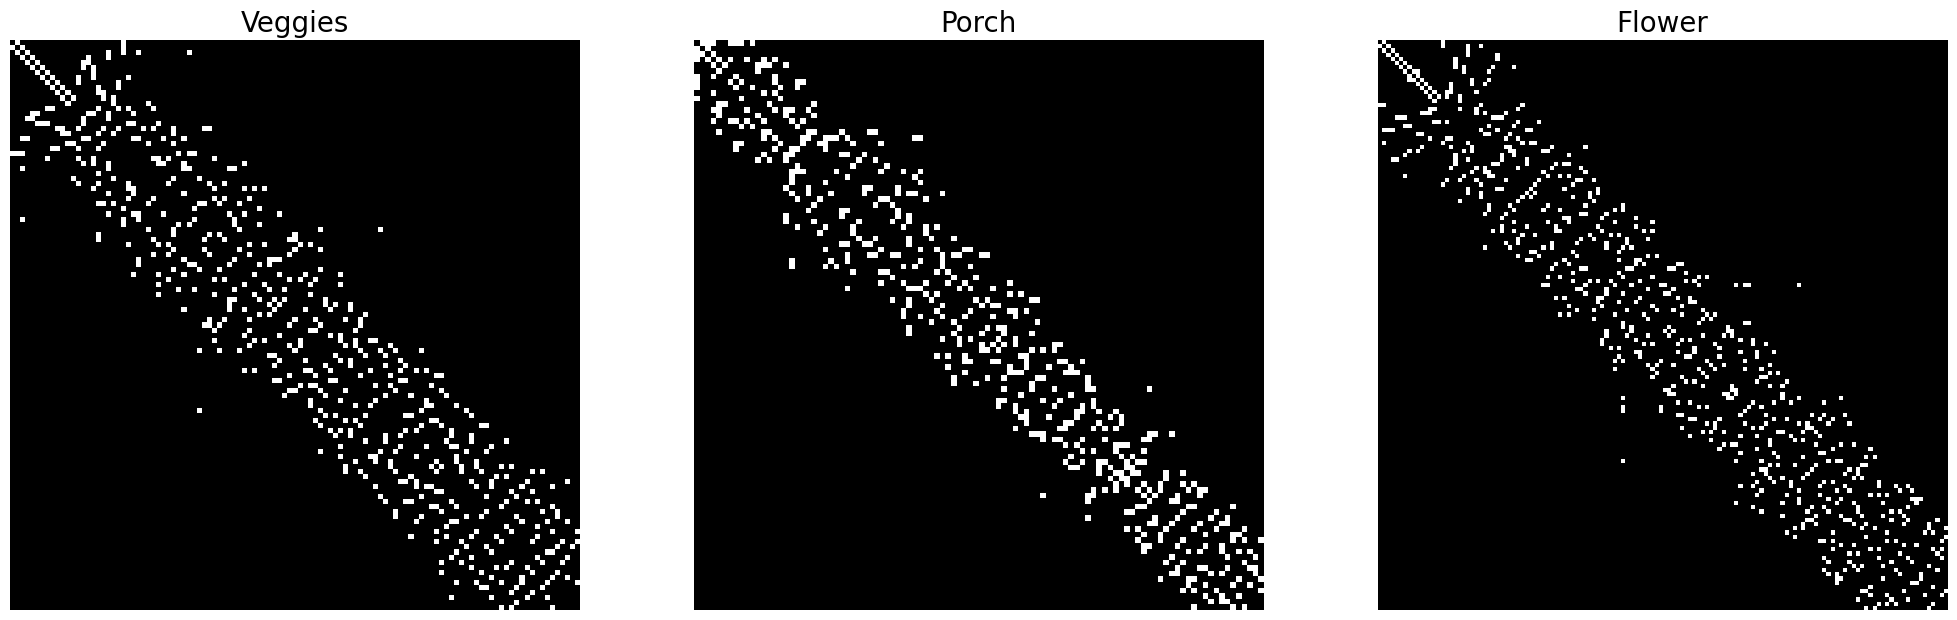

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(25,25))
images = [veggies, porch, flower]
maps = [super_veggies, super_porch, super_flower]

adjMatrix_veggies = adjacencyMatrix(super_veggies)
adjMatrix_porch = adjacencyMatrix(super_porch)
adjMatrix_flower = adjacencyMatrix(super_flower)



ax[0].set_axis_off()
ax[0].set_title('Veggies', fontsize=20)
ax[0].imshow(adjMatrix_veggies, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title('Porch', fontsize=20)
ax[1].imshow(adjMatrix_porch, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title('Flower', fontsize=20)
ax[2].imshow(adjMatrix_flower, cmap="gray")




# Calculate average node degree

You will implement a function that takes an adjacency matrix as input and outputs the average node degree. This is the average number of neighborghs that segments have.

In [117]:
def average_node_degree(adjMatrix):
  """ This function takes an adjacency matrix and returns
  the average number of neighborghs that the segments have
  (average node degree)"""

  # ===============================================
  # TODO: replace pass with your code
  total_neighbors = 0
  for i in range(adjMatrix.shape[0]):
    row = adjMatrix[i,:]
    neighbors = np.count_nonzero(row == 1)
    total_neighbors = total_neighbors + neighbors

  average_node_degree = total_neighbors/adjMatrix.shape[0]

  # ===============================================

  return average_node_degree

# Check your implementation

This will check that your adjacency maps and average_node_degree function works correctly. Errors should be very close to 0.


In [118]:
print("Error on veggies: ", 5.221238938053097 - average_node_degree(adjMatrix_veggies))
print("Error on porch: ",5.196078431372549 - average_node_degree(adjMatrix_porch))
print("Error on flower: ",5.235294117647059 - average_node_degree(adjMatrix_flower))

Error on veggies:  0.0
Error on porch:  0.0
Error on flower:  0.0


# Implement your graph-cut algorithm

It is time to build your foreground-background segmentation algorithm. For this we provide you with the implementation of the Ford-fulkerson algorithm which you will need to determine where your graph should be cut. You can learn more about the algorithm here: https://www.geeksforgeeks.org/ford-fulkerson-algorithm-for-maximum-flow-problem/. Please note that our version of the Ford Fulkerson algorithm doesn't return the max flow as a scalar. It returns the current flow through each edge of the graph when we reach the point of maximum flow.

We also implemented the reduce function which takes an image, its corresponding superpixel map, and a number of bins as input. The output is a list of feature vectors. Each feature vector is the resulting histogram from applying the color_histogram function you implemented to every segment on the superpixel map.

You will implement the graph_cut function


In [119]:
# Python program for implementation of Ford Fulkerson algorithm
# The author of this code is Neelam Yadav

from collections import defaultdict

#This class represents a directed graph using adjacency matrix representation
class Graph:

    def __init__(self,graph):
        self.graph = graph # residual graph
        self. ROW = len(graph)
        # self.COL = len(gr[0])


    '''Returns true if there is a path from source 's' to sink 't' in
    residual graph. Also fills parent[] to store the path '''
    def BFS(self,s, t, parent):

        # Mark all the vertices as not visited
        visited =[False]*(self.ROW)

        # Create a queue for BFS
        queue=[]

        # Mark the source node as visited and enqueue it
        queue.append(s)
        visited[s] = True

         # Standard BFS Loop
        while queue:

            #Dequeue a vertex from queue and print it
            u = queue.pop(0)

            # Get all adjacent vertices of the dequeued vertex u
            # If a adjacent has not been visited, then mark it
            # visited and enqueue it
            for ind, val in enumerate(self.graph[u]):
                if visited[ind] == False and val > 0 :
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        # If we reached sink in BFS starting from source, then return
        # true, else false
        return True if visited[t] else False


    # Returns tne current flow from s to t in the given graph
    def FordFulkerson(self, source, sink):

        # This array is filled by BFS and to store path
        parent = [-1]*(self.ROW)

        max_flow = 0 # There is no flow initially
        current_flow = np.zeros_like(self.graph)

        # Augment the flow while there is path from source to sink
        while self.BFS(source, sink, parent) :
            # Find minimum residual capacity of the edges along the
            # path filled by BFS. Or we can say find the maximum flow
            # through the path found.
            path_flow = float("Inf")
            s = sink
            while(s !=  source):
                path_flow = min (path_flow, self.graph[parent[s]][s])
                s = parent[s]

            # Add path flow to overall flow
            max_flow +=  path_flow

            # update residual capacities of the edges and reverse edges
            # along the path
            v = sink
            while(v !=  source):
                u = parent[v]
                self.graph[u][v] -= path_flow
                self.graph[v][u] += path_flow
                current_flow[u][v] += path_flow
                current_flow[v][u] -= path_flow
                v = parent[v]

        return current_flow


In [120]:
def reduce(img, superpixel_map, num_bins=10):
  """This function takes as input an image, its corresponding superpixel map, and a
  number of bins as input. The output is a list of feature vectors.
  Each feature vector is the resulting histogram from applying the color_histogram
  function you implemented to every segment on the superpixel map."""

  feature_vectors = []
  num_segments = len(np.unique(superpixel_map))
  for i in range(num_segments):
      mask = superpixel_map == i
      feature_vectors.append(color_histogram(img, mask, num_bins))
  return(feature_vectors)

In [121]:
def graph_cut(superpixel_map, features, centers, keyindex):
  """Function to take a superpixel set and a keyindex and convert to a
  foreground/background segmentation.

  keyindex is the index to the superpixel segment we wish to use as foreground and
  find its relevant neighbors.

  centers is a list of tuples (row, col) with the positions of the cluster centers
  of the superpixel_map

  features is a list of histograms (obtained from the reduce function) for every superpixel
  segment in an image.

  """

  #Compute basic adjacency information of superpixels
  #Note that adjacencyMatrix is code you need to implement

  # ===============================================
  # TODO: this should be one line of code

  adjMatrix = adjacencyMatrix(superpixel_map)

  # ===============================================


  # normalization for distance calculation based on the image size
  # for points (x1,y1) and (x2,y2), distance is
  # exp(-||(x1,y1)-(x2,y2)||^2/dnorm)
  dnorm = 2*(superpixel_map.shape[0]/2 *superpixel_map.shape[1] /2)**2
  k = len(features) #number of superpixels in image

  #Generate capacity matrix
  capacity = np.zeros((k+2,k+2))
  source = k
  sink = k+1

  # This is a single planar graph with an extra source and sink
  #  Capacity of a present edge in the graph is to be defined as the product of
  #  1:  the histogram similarity between the two color histogram feature vectors.
  #  The similarity between histograms should be computed as the intersections between
  #  the histograms. i.e: sum(min(histogram 1, histogram 2))
  #  2:  the spatial proximity between the two superpixels connected by the edge.
  #      use exp(-||(x1,y1)-(x2,y2)||^2/dnorm)
  #
  #  Source gets connected to every node except sink
  #  Capacity is with respect to the keyindex superpixel
  #  Sink gets connected to every node except source and its capacity is opposite
  # The weight between a pixel and the sink is going to be the max of all the weights between
  # the source and the image pixels minus the weight between that specific pixel and the source.
  # Other superpixels get connected to each other based on computed adjacency
  # matrix: the capacity is defined as above, EXCEPT THAT YOU ALSO NEED TO MULTIPLY BY A SCALAR 0.25 for
  # adjacent superpixels.


  key_features = features[keyindex] # color histogram representation of superpixel # keyindex
  key_x = centers[keyindex][1] # row of cluster center for superpixel # keyindex
  key_y =  centers[keyindex][0] # col of cluster center for superpixel # keyindex

  # ===============================================
  # TODO: Generate the capacity matrix using the description above. Replace pass with your code

  for i in range(k+2):
    for j in range(k+2):
      if i<k and j<k and i!=j:
        if adjMatrix[i,j]==1:
          hist_similarity = np.sum(np.minimum(features[i], features[j]))
          x1 = centers[i][1]
          y1 = centers[i][0]
          x2 = centers[j][1]
          y2 = centers[j][0]
          spatial_similarity = np.exp(-((x1-x2)**2 + (y1-y2)**2)/dnorm)
          capacity[i,j] = 0.25*hist_similarity*spatial_similarity
      if i==k and j<k:
        hist_similarity = np.sum(np.minimum(features[j], key_features))
        x1 = centers[j][1]
        y1 = centers[j][0]
        x2 = key_x
        y2 = key_y
        spatial_similarity = np.exp(-((x1-x2)**2 + (y1-y2)**2)/dnorm)
        capacity[i,j] = hist_similarity*spatial_similarity
      if j==k+1 and i<k:
        hist_similarity = np.sum(np.minimum(features[i], key_features))
        x1 = centers[i][1]
        y1 = centers[i][0]
        x2 = key_x
        y2 = key_y
        spatial_similarity = np.exp(-((x1-x2)**2 + (y1-y2)**2)/dnorm)
        capacity[i,j] = hist_similarity*spatial_similarity
  #Now doing for the sink
  largest_weight = np.max([capacity[k, i] for i in range(k)])
  for i in range(k+2):
    if i!=k:
      capacity[i, k+1] = largest_weight - capacity[k, i]

  # ===============================================

  # Obtaining the current flow of the graph when the flow is max
  capacity = (1e6*capacity).astype('int') ##################### CHANGED
  g = Graph(capacity.copy())
  current_flow = g.FordFulkerson(source, sink)

  # Extract the two-class segmentation.
  # the cut will separate all nodes into those connected to the
  # source and those connected to the sink.
  # The current_flow matrix contains the necessary information about
  # the max-flow through the graph.

  segment_map = np.zeros_like(superpixel_map)
  rem_capacity = capacity - current_flow

  # ===============================================
  # TODO: Do the segmentation and fill segmentation map with 1s where the foreground is.
  # Replace pass with your code

  for i in range(k+2):
    if rem_capacity[k, i]!=0:
      segment_map[superpixel_map==i] = 1
      graph = Graph(rem_capacity.copy())
      parent = [-1]*(graph.ROW)

      graph.BFS(k, i, parent)

      for nd, prnt_nd in enumerate(parent):
        if prnt_nd !=-1 and prnt_nd !=k+1:
          segment_map[superpixel_map==nd] = 1
  # ===============================================

  return capacity, segment_map


# Visualize capacity matrix

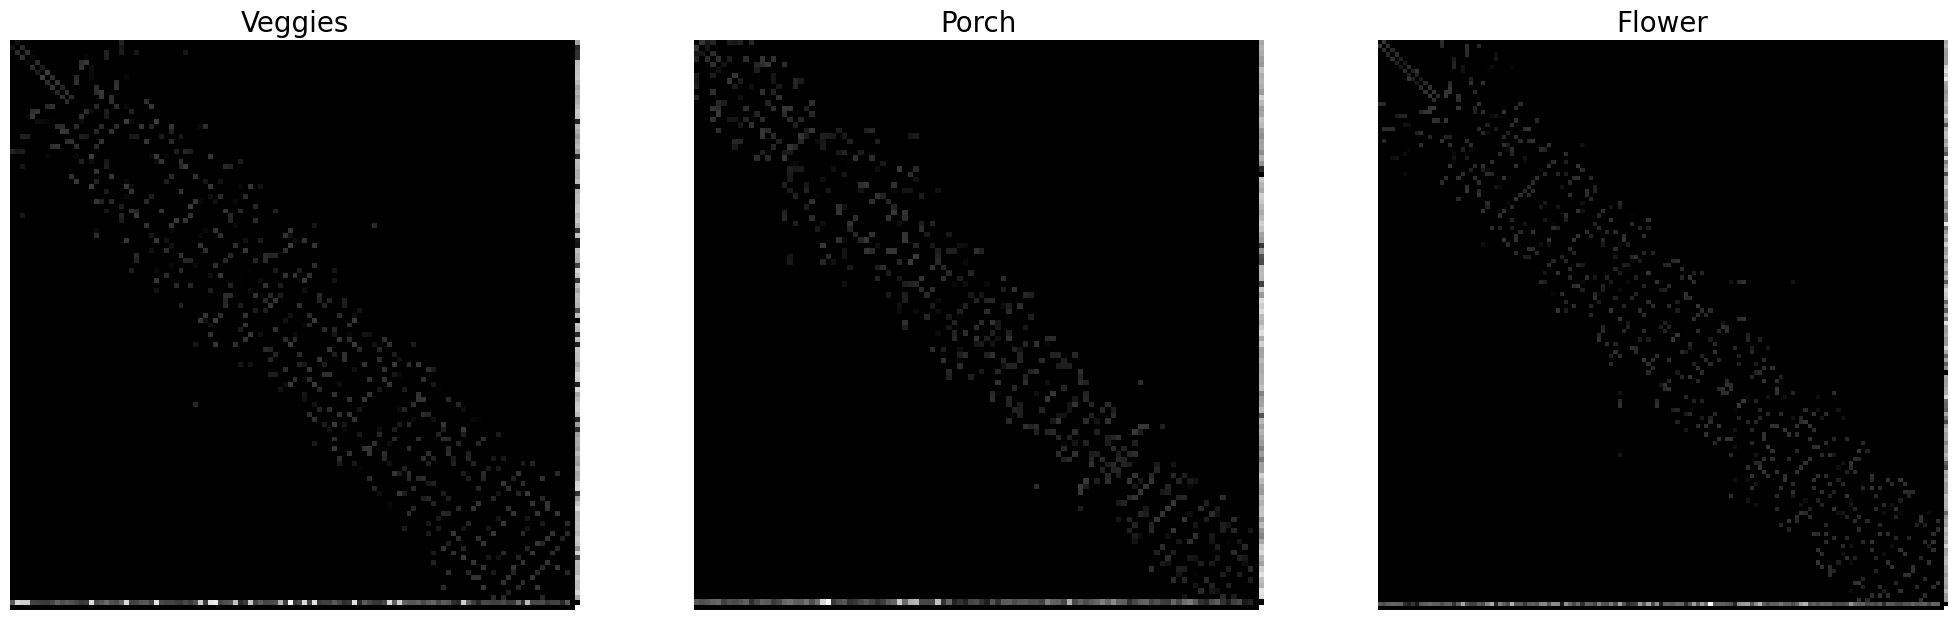

In [122]:
veggies_features = reduce(veggies, super_veggies)
veggies_centers = cluster_centers(super_veggies)
veggies_capacity, veggies_segment_map = graph_cut(super_veggies, veggies_features, veggies_centers, 56) ##################### CHANGED

porch_features = reduce(porch, super_porch)
porch_centers = cluster_centers(super_porch)
porch_capacity,porch_segment_map = graph_cut(super_porch, porch_features, porch_centers, 24)

flower_features = reduce(flower, super_flower)
flower_centers = cluster_centers(super_flower)
flower_capacity,flower_segment_map = graph_cut(super_flower, flower_features, flower_centers, 80)


fig, ax = plt.subplots(1, 3, figsize=(25,25))
ax[0].set_axis_off()
ax[0].set_title('Veggies', fontsize=20)
ax[0].imshow(veggies_capacity, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title('Porch', fontsize=20)
ax[1].imshow(porch_capacity, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title('Flower', fontsize=20)
ax[2].imshow(flower_capacity, cmap="gray")
ax[2].set_axis_off()


# Visualizing graphcut segmentation

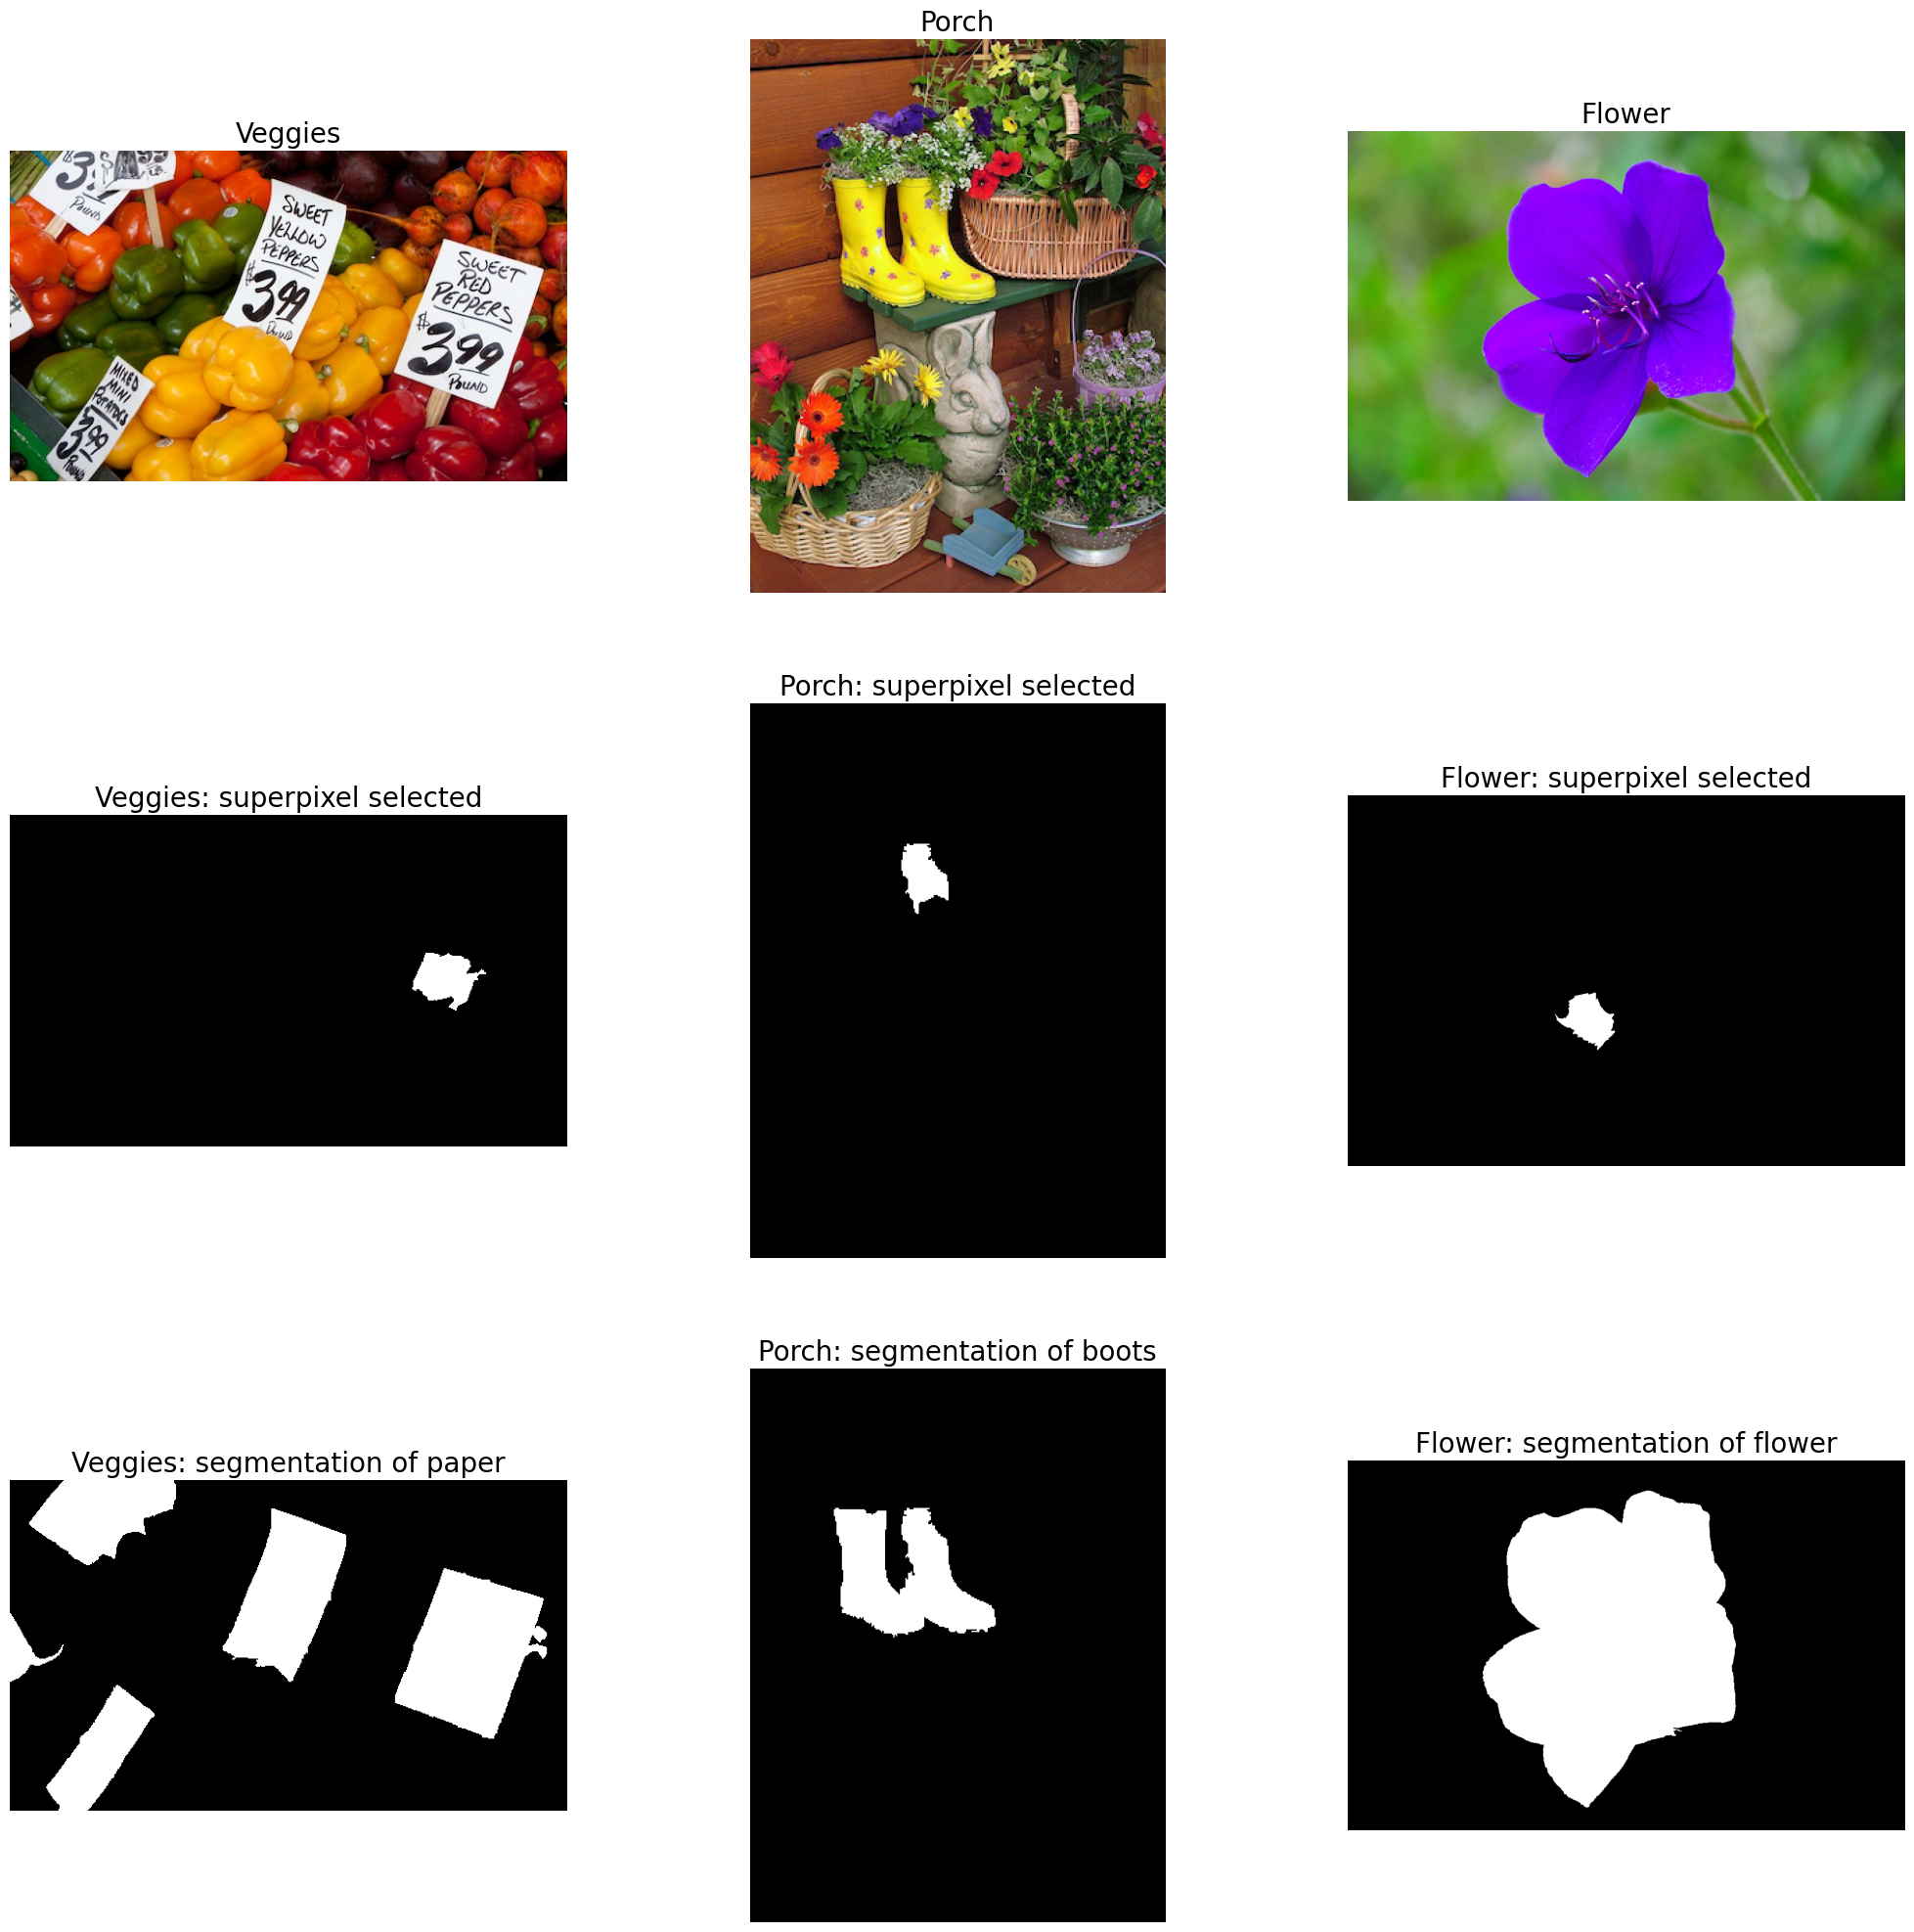

In [123]:
fig, ax = plt.subplots(3, 3, figsize=(25,25))

ax[0][0].set_axis_off()
ax[0][0].set_title('Veggies', fontsize=20)
ax[0][0].imshow(veggies, cmap="gray")
ax[0][1].set_axis_off()
ax[0][1].set_title('Porch', fontsize=20)
ax[0][1].imshow(porch, cmap="gray")
ax[0][2].set_axis_off()
ax[0][2].set_title('Flower', fontsize=20)
ax[0][2].imshow(flower, cmap="gray")
ax[0][2].set_axis_off()

ax[1][0].set_axis_off()
ax[1][0].set_title('Veggies: superpixel selected', fontsize=20)
ax[1][0].imshow(super_veggies==56, cmap="gray")       ##################### CHANGED
ax[1][1].set_axis_off()
ax[1][1].set_title('Porch: superpixel selected', fontsize=20)
ax[1][1].imshow(super_porch==24, cmap="gray")
ax[1][2].set_axis_off()
ax[1][2].set_title('Flower: superpixel selected', fontsize=20)
ax[1][2].imshow(super_flower==80, cmap="gray")
ax[1][2].set_axis_off()

ax[2][0].set_axis_off()
ax[2][0].set_title('Veggies: segmentation of paper', fontsize=20)
ax[2][0].imshow(veggies_segment_map, cmap="gray")
ax[2][1].set_axis_off()
ax[2][1].set_title('Porch: segmentation of boots', fontsize=20)
ax[2][1].imshow(porch_segment_map, cmap="gray")
ax[2][2].set_axis_off()
ax[2][2].set_title('Flower: segmentation of flower', fontsize=20)
ax[2][2].imshow(flower_segment_map, cmap="gray")
ax[2][2].set_axis_off()


# Problem: Segmentation with minimum spanning forest

Now we do the segmentation using the Felzenszwalb-Huttenlocher algorithm (http://vision.stanford.edu/teaching/cs231b_spring1415/slides/ranjay_pres.pdf). This algorithm will segment into multiple groups as opposed to the graph-cut algorithm you implemented which will only did foreground-background segmentation.


The first step will be to implement the function compute_MSF_edges.

In [124]:
def compute_MSF_edges(superpixel_map, adjMatrix, centers, features):
  """ For this function you will turn the adjacency matrix into a  mx3 matrix,
  of which each row is an edge (node1, node2, weights). You will return this matrix.

  m is the number of edges. You should avoid duplicated edges. You will only use
  the edges where the adjacency matrix is 1 (between neighbors)

  The edge weight is defined as the product of (1) difference of histograms
  (or equivalently, 1-intersection of histograms/3), and (2) inverse
  proximity exp(D(a,b)) with D specified below.
  Notice the difference between the weights here and those in graph cuts.

  Normalization for distance calculation based on the image size
  For points (x1,y1) and (x2,y2), normalized distance D =
  ||(x1,y1)-(x2,y2)||^2/dnorm.

  hint: np.triu, np.where (you don't necessarily need to use these)"""


  rows, cols = superpixel_map.shape
  dnorm = np.sum(rows**2 + cols**2)
  n, _  = adjMatrix.shape

  G = None

  # ===============================================
  # TODO: Replace pass with your code
  G = np.zeros((n, 3))
  edges_list = []
  for i in range(n):
    for j in range(n):
      if adjMatrix[i,j]==1 and j>=i:
        hist_difference = 1 - np.sum(np.minimum(features[i], features[j]))/3.0
        x1 = centers[i][1]
        y1 = centers[i][0]
        x2 = centers[j][1]
        y2 = centers[j][0]
        spatial_similarity = np.exp(-((x1-x2)**2 + (y1-y2)**2)/dnorm)
        weight = hist_difference*spatial_similarity
        edges_list.append([i, j, weight])

  G = np.array(edges_list)
  # ===============================================

  return G

Now, you need to implement the minimum random forest segmentation (MSF) function below. We recommend that you implement MSF before filter_segments, even though you will have to run filter_segments first so that MSF works.

YOU SHOULD IMPLEMENT FILTER_SEGMENTS AFTER YOU IMPLEMENT MSF

In [125]:
def filter_segments(edges, seg_id, min_size):
  """A common postprocessing step used with F-H is to merge all of the small, unnecessary components that result from uneven
  regions. This function should 1) iterate through the edges, in
  ascending order, and 2) for each edge, if it connects two distinct segments, AND if at least one of those segments contains less
  than min_size pixels in it, merge the segments.

  You will change seg_id and return it. This function will be used in MSF.
  """

  num_edges = edges.shape[0]

  # ===============================================
  # TODO: Replace pass with your code
  for i in range(num_edges):
    nd_1, nd_2, _ = edges[i]
    prnt_nd_1 = seg_id[int(nd_1)]
    prnt_nd_2 = seg_id[int(nd_2)]

    #finding how many pixels in each of the two segments
    num_seg1 = np.sum(seg_id==prnt_nd_1)
    num_seg2 = np.sum(seg_id==prnt_nd_2)
    #making sure if it connects two separate segments
    if prnt_nd_1!=prnt_nd_2:
      if (num_seg1<min_size) or (num_seg2<min_size):
        #merging the segments
        seg_id[seg_id==prnt_nd_1] = prnt_nd_2

  # ===============================================

  return seg_id

In [126]:
def MSF(edges, k, filter_min_size=None):
  """Felzenszwalb-Huttenlocher algorithm implementation, which is a modified
  version of the Kruskal algorithm.
  Input  edges: mx3 matrix, the adjacency list of a graph, of which each row is
            an edge (node1, node2, weights).
         m: is the number of edges.
         k: hyperparameter for F-H algorithm
         filter_size: if a filter size is passed, this will remove groups from the
         segmentation that have less than filter_size superpixels
  Output seg: array of size (n,), the segment id assigned to each node in the graph
              n is the number of nodes"""

  num_edges = edges.shape[0]
  num_nodes = int(np.max(edges[:,:2])) +1

  # Sort edges in ascending order
  edges = edges[np.argsort(edges[:,2]), :]

  # You will assign every pixel to the id corresponding to a segment id. Initially,
  # every superpixel is in its own segment.
  seg_id = np.array(list(range(num_nodes)))


  # ===============================================
  # TODO: Replace pass with your code
  IntS = np.zeros(num_nodes)
  num_seg = np.ones(num_nodes)

  for i in range(num_edges):
    nd_1, nd_2, wt = edges[i]
    prnt_nd_1 = seg_id[int(nd_1)]
    prnt_nd_2 = seg_id[int(nd_2)]

    if prnt_nd_1!=prnt_nd_2:
      if (wt<np.minimum((IntS[prnt_nd_1]+(k/num_seg[prnt_nd_1])), (IntS[prnt_nd_2]+(k/num_seg[prnt_nd_2])))):
        IntS[prnt_nd_1]=wt
        IntS[prnt_nd_2]=wt
        seg_id[seg_id==prnt_nd_1]=prnt_nd_2
        num_seg[prnt_nd_2]=np.sum(seg_id==prnt_nd_2)
  # ===============================================

  if filter:
    # Postprocessing to remove fragments
    seg_id = filter_segments(edges, seg_id, filter_min_size)


  return seg_id


# Visualize MSF segmentations

This will show you your segmentations with and without filtering.

In [127]:
def build_msf_map(segmentation, superpixel_map):

  num_nodes = len(segmentation)
  map = np.zeros_like(superpixel_map)
  rows, cols = map.shape
  for row in range(rows):
    for col in range(cols):
      map[row, col] = segmentation[superpixel_map[row, col]]
  return map

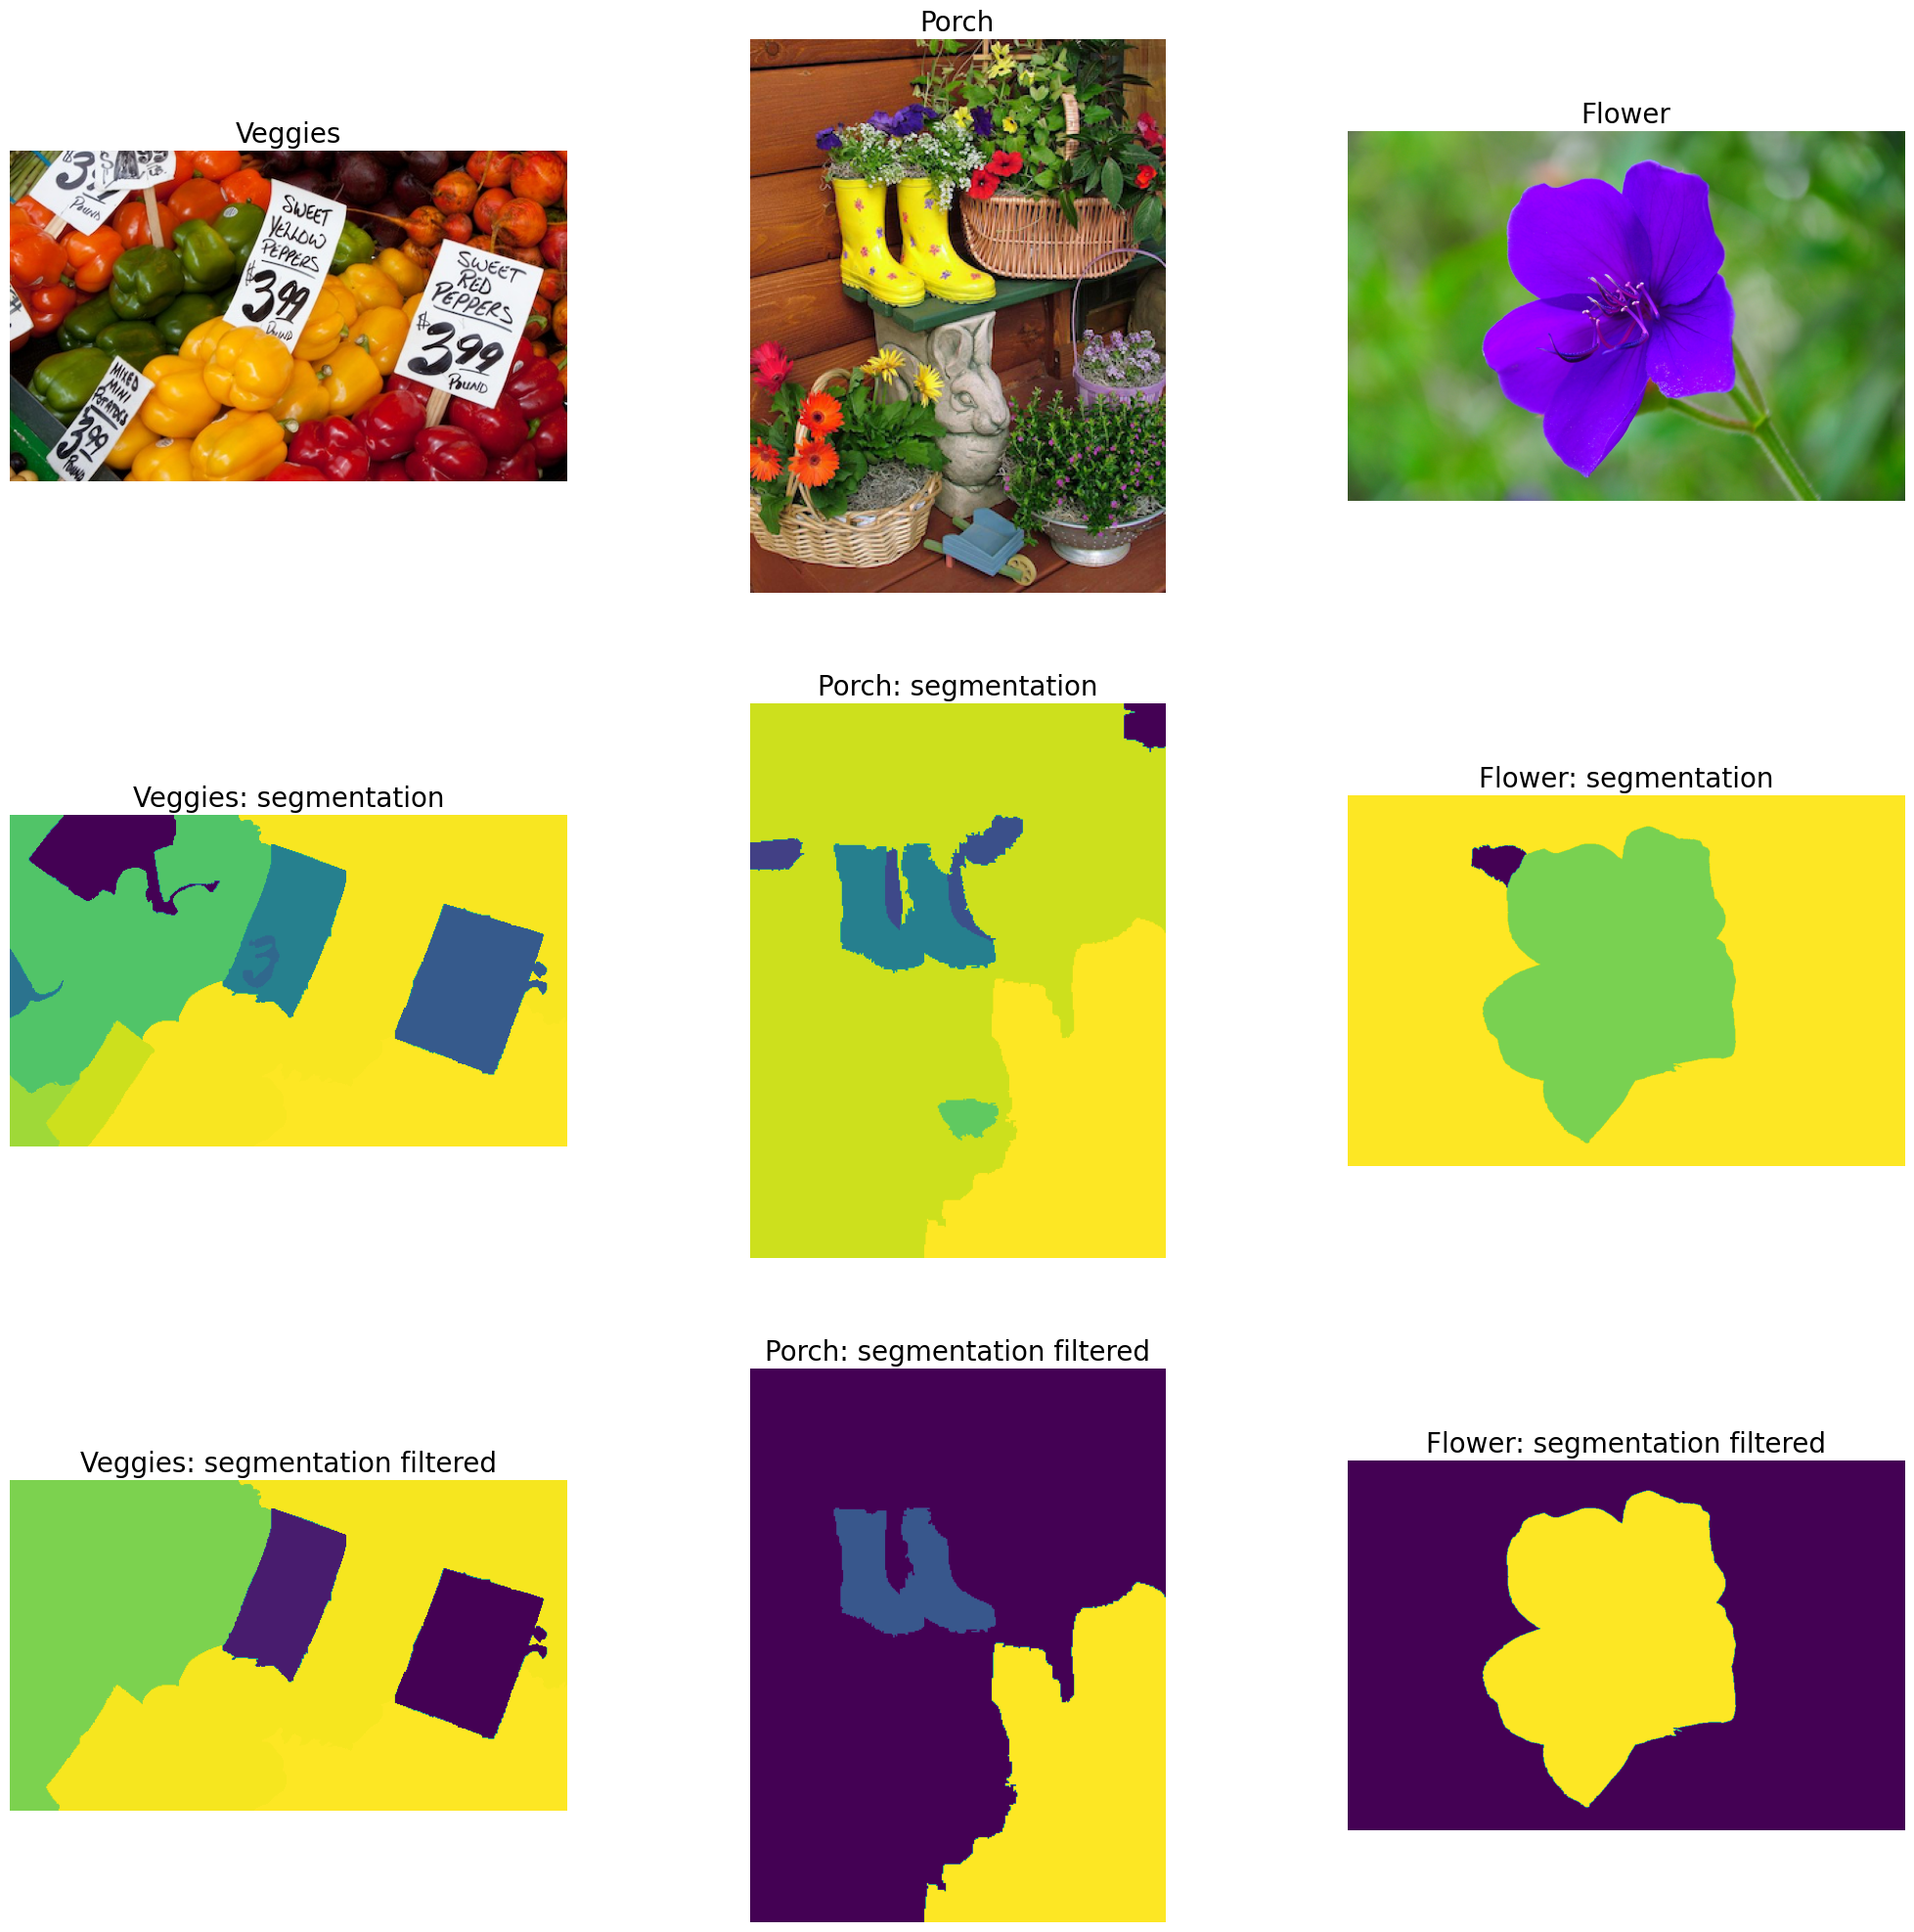

In [128]:
edges_veggies = compute_MSF_edges(super_veggies, adjMatrix_veggies, veggies_centers, veggies_features)
edges_porch = compute_MSF_edges(super_porch, adjMatrix_porch, porch_centers, porch_features)
edges_flower = compute_MSF_edges(super_flower, adjMatrix_flower, flower_centers, flower_features)

segmentation_veggies = MSF(edges_veggies,1, 0)
segmentation_porch = MSF(edges_porch,1, 0)
segmentation_flower = MSF(edges_flower,4, 0)

veggies_map = build_msf_map(segmentation_veggies, super_veggies)
porch_map = build_msf_map(segmentation_porch, super_porch)
flower_map = build_msf_map(segmentation_flower, super_flower)

segmentation_veggies = MSF(edges_veggies,1, 5)
segmentation_porch = MSF(edges_porch,1, 3)
segmentation_flower = MSF(edges_flower,4, 15)

veggies_map_filtered = build_msf_map(segmentation_veggies, super_veggies)
porch_map_filtered = build_msf_map(segmentation_porch, super_porch)
flower_map_filtered = build_msf_map(segmentation_flower, super_flower)


fig, ax = plt.subplots(3, 3, figsize=(25,25))

ax[0][0].set_axis_off()
ax[0][0].set_title('Veggies', fontsize=20)
ax[0][0].imshow(veggies)
ax[0][1].set_axis_off()
ax[0][1].set_title('Porch', fontsize=20)
ax[0][1].imshow(porch)
ax[0][2].set_axis_off()
ax[0][2].set_title('Flower', fontsize=20)
ax[0][2].imshow(flower)
ax[0][2].set_axis_off()

ax[1][0].set_axis_off()
ax[1][0].set_title('Veggies: segmentation', fontsize=20)
ax[1][0].imshow(veggies_map)
ax[1][1].set_axis_off()
ax[1][1].set_title('Porch: segmentation', fontsize=20)
ax[1][1].imshow(porch_map)
ax[1][2].set_axis_off()
ax[1][2].set_title('Flower: segmentation', fontsize=20)
ax[1][2].imshow(flower_map)
ax[1][2].set_axis_off()

ax[2][0].set_axis_off()
ax[2][0].set_title('Veggies: segmentation filtered', fontsize=20)
ax[2][0].imshow(veggies_map_filtered)
ax[2][1].set_axis_off()
ax[2][1].set_title('Porch: segmentation filtered', fontsize=20)
ax[2][1].imshow(porch_map_filtered)
ax[2][2].set_axis_off()
ax[2][2].set_title('Flower: segmentation filtered', fontsize=20)
ax[2][2].imshow(flower_map_filtered)
ax[2][2].set_axis_off()

In [129]:
%%capture

!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [130]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
# Give the path to your notebook here.
# Find the location of your notebook using File->Locate in Drive
# Example: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS2_FA_2022_Starter_Code.ipynb'

notebookpath = "/content/drive/My Drive/Colab Notebooks/EECS504_PS3_suryasin_45029014.ipynb"
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
20 packages can be upgraded. Run 'apt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>